In [11]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import cv2
# from PIL import Image, ImageChops, ImageEnhance
# import tensorflow as tf
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import (
#     confusion_matrix, 
#     classification_report, 
#     precision_score, 
#     recall_score, 
#     f1_score, 
#     accuracy_score
# )
# class ForgeryDetector:
#     def __init__(self, dataset_path):
#         """
#         Initialize Forgery Detector
#         """
#         self.dataset_path = dataset_path
#         self.model = None
#         self.history = None
    
#     def gaussian_blur_difference(self, image_path):
#         """
#         Calculate difference image using Gaussian Blur
#         """
#         original_image = cv2.imread(image_path)
#         gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
#         blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#         diff = cv2.absdiff(gray, blurred)
#         diff_color = cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)
#         return diff_color

#     def error_level_analysis(self, image_path, quality=98):
#         """
#         Perform Error Level Analysis
#         """
#         try:
#             original = Image.open(image_path)
#             temp_compressed = 'temp_compressed.jpg'
#             original.save(temp_compressed, 'JPEG', quality=quality)
#             compressed = Image.open(temp_compressed)
#             ela_image = ImageChops.difference(original, compressed)
#             ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
#             os.remove(temp_compressed)
#             ela_cv = cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
#             return ela_cv
#         except Exception as e:
#             print(f"ELA Error: {e}")
#             return None

#     def preprocess_image(self, image_path):
#         """
#         Preprocess image with Gaussian Blur and ELA
#         """
#         gb_diff = self.gaussian_blur_difference(image_path)
#         ela_image = self.error_level_analysis(image_path)
        
#         if ela_image is None:
#             return None
        
#         gb_resized = cv2.resize(gb_diff, (160, 160))
#         ela_resized = cv2.resize(ela_image, (160, 160))
        
#         combined = cv2.addWeighted(gb_resized, 0.2, ela_resized, 0.8, 0)
#         return combined

#     def prepare_dataset(self):
#         """
#         Prepare dataset with preprocessing
#         """
#         X, y = [], []
        
#         # Process non-forged images
#         non_forged_path = os.path.join(self.dataset_path, 'Au')
#         for img_file in os.listdir(non_forged_path):
#             if not img_file.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
#                 continue
#             img_path = os.path.join(non_forged_path, img_file)
#             processed_img = self.preprocess_image(img_path)
            
#             if processed_img is not None:
#                 X.append(processed_img)
#                 y.append(0)  # Non-forged
        
#         # Process forged images
#         forged_path = os.path.join(self.dataset_path, 'Tp')
#         for img_file in os.listdir(forged_path):
#             if not img_file.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
#                 continue
#             img_path = os.path.join(forged_path, img_file)
#             processed_img = self.preprocess_image(img_path)
            
#             if processed_img is not None:
#                 X.append(processed_img)
#                 y.append(1)  # Forged
        
#         # Convert to numpy arrays
#         X = np.array(X)
#         y = np.array(y)
        
#         return X, y

#     def build_model(self):
#         """
#         Build MobileNetV2 model for forgery detection
#         """
#         base_model = MobileNetV2(
#             weights='imagenet', 
#             include_top=False, 
#             input_shape=(160, 160, 3)
#         )
        
#         base_model.trainable = False
        
#         x = base_model.output
#         x = Flatten()(x)
#         x = Dense(1024, activation='relu')(x)
#         x = Dropout(0.5)(x)
#         x = Dense(512, activation='relu')(x)
#         x = Dropout(0.5)(x)


#         output = Dense(1, activation='sigmoid')(x)
        
#         self.model = Model(inputs=base_model.input, outputs=output)
        
#         self.model.compile(
#             optimizer=Adam(learning_rate=1e-5),
#             loss='binary_crossentropy',
#             metrics=['accuracy']
#         )
        
#         return self.model

#     def train_model(self, X, y):
#         """
#         Train the model and return train/test split
#         """
#         # Preprocess input
#         X = preprocess_input(X)
        
#         # Split dataset
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
        
#         # Train model
#         self.history = self.model.fit(
#             X_train, y_train,
#             validation_split=0.25,
#             epochs=30,
#         )
        
#         return X_train, X_test, y_train, y_test

#     def plot_training_curves(self):
#         """
#         Plot accuracy and loss curves
#         """
#         plt.figure(figsize=(12, 4))
        
#         # Accuracy subplot
#         plt.subplot(1, 2, 1)
#         plt.plot(self.history.history['accuracy'], label='Training Accuracy')
#         plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
#         plt.title('Model Accuracy')
#         plt.xlabel('Epoch')
#         plt.ylabel('Accuracy')
#         plt.legend()
        
#         # Loss subplot
#         plt.subplot(1, 2, 2)
#         plt.plot(self.history.history['loss'], label='Training Loss')
#         plt.plot(self.history.history['val_loss'], label='Validation Loss')
#         plt.title('Model Loss')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.legend()
        
#         plt.tight_layout()
#         plt.savefig('training_curves.png')
#         plt.show()

#     def evaluate_model(self, X_test, y_test):
#         """
#         Comprehensive model evaluation
#         """
#         # Predict
#         y_pred = (self.model.predict(X_test) > 0.5).astype(int).flatten()
        
#         # Compute metrics
#         accuracy = accuracy_score(y_test, y_pred)
#         precision = precision_score(y_test, y_pred)
#         recall = recall_score(y_test, y_pred)
#         f1 = f1_score(y_test, y_pred)
        
#         # Print detailed classification report
#         print("\nClassification Report:")
#         print(classification_report(y_test, y_pred))
        
#         # Confusion Matrix
#         cm = confusion_matrix(y_test, y_pred)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#                     xticklabels=['Non-Forged', 'Forged'],
#                     yticklabels=['Non-Forged', 'Forged'])
#         plt.title('Confusion Matrix')
#         plt.xlabel('Predicted')
#         plt.ylabel('Actual')
#         plt.tight_layout()
#         plt.savefig('confusion_matrix.png')
#         plt.show()
        
#         # Return metrics
#         return {
#             'accuracy': accuracy,
#             'precision': precision,
#             'recall': recall,
#             'f1_score': f1
#         }




In [4]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image, ImageChops, ImageEnhance


class ForgeryDetector:
    def __init__(self, dataset_path):
        """
        Initialize Forgery Detector
        """
        self.dataset_path = dataset_path
        self.model = None
        self.history = None

    def gaussian_blur_difference(self, image_path):
        """
        Calculate difference image using Gaussian Blur
        """
        original_image = cv2.imread(image_path)
        gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        diff = cv2.absdiff(gray, blurred)
        diff_color = cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)
        return diff_color

    def error_level_analysis(self, image_path, quality=98):
        """
        Perform Error Level Analysis
        """
        try:
            original = Image.open(image_path)
            temp_compressed = 'temp_compressed.jpg'
            original.save(temp_compressed, 'JPEG', quality=quality)
            compressed = Image.open(temp_compressed)
            ela_image = ImageChops.difference(original, compressed)
            ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
            os.remove(temp_compressed)
            ela_cv = cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
            return ela_cv
        except Exception as e:
            print(f"ELA Error: {e}")
            return None

    def preprocess_image(self, image_path):
        """
        Preprocess image with Gaussian Blur and ELA
        """
        gb_diff = self.gaussian_blur_difference(image_path)
        ela_image = self.error_level_analysis(image_path)

        if ela_image is None:
            return None

        gb_resized = cv2.resize(gb_diff, (160, 160))
        ela_resized = cv2.resize(ela_image, (160, 160))

        combined = cv2.addWeighted(gb_resized, 0.2, ela_resized, 0.8, 0)
        return combined

    def prepare_dataset(self):
        """
        Prepare dataset with preprocessing
        """
        X, y = [], []

        # Process non-forged images
        non_forged_path = os.path.join(self.dataset_path, 'Au')
        for img_file in os.listdir(non_forged_path):
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                continue
            img_path = os.path.join(non_forged_path, img_file)
            processed_img = self.preprocess_image(img_path)

            if processed_img is not None:
                X.append(processed_img)
                y.append(0)  # Non-forged

        # Process forged images
        forged_path = os.path.join(self.dataset_path, 'Tp')
        for img_file in os.listdir(forged_path):
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                continue
            img_path = os.path.join(forged_path, img_file)
            processed_img = self.preprocess_image(img_path)

            if processed_img is not None:
                X.append(processed_img)
                y.append(1)  # Forged

        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)

        return X, y

    def build_model(self):
        """
        Build MobileNetV2 model for forgery detection
        """
        base_model = MobileNetV2(
            weights='imagenet', 
            include_top=False, 
            input_shape=(160, 160, 3)
        )

        base_model.trainable = False

        x = base_model.output
        x = Flatten()(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.6)(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.6)(x)

        output = Dense(1, activation='sigmoid')(x)

        self.model = Model(inputs=base_model.input, outputs=output)

        self.model.compile(
            optimizer=Adam(learning_rate=1e-5),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def train_model(self, X, y):
        """
        Train the model with Early Stopping and Learning Rate Scheduler
        """
        # Preprocess input
        X = preprocess_input(X)

        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

        # Train model
        self.history = self.model.fit(
            X_train, y_train,
            validation_split=0.25,
            epochs=50,
            callbacks=[lr_scheduler]
        )

        return X_train, X_test, y_train, y_test

    def plot_training_curves(self):
        """
        Plot accuracy and loss curves
        """
        plt.figure(figsize=(12, 4))

        # Accuracy subplot
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss subplot
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_curves.png')
        plt.show()

    def evaluate_model(self, X_test, y_test):
        """
        Comprehensive model evaluation
        """
        # Predict
        y_pred = (self.model.predict(X_test) > 0.5).astype(int).flatten()

        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Print detailed classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Non-Forged', 'Forged'],
                    yticklabels=['Non-Forged', 'Forged'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()

        # Return metrics
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

In [5]:
# Dataset path
dataset_path = r"./CASIA22"

# Initialize detector
detector = ForgeryDetector(dataset_path)

# Prepare dataset
X, y = detector.prepare_dataset()

print(X.shape, y.shape, "------")

# Build model
model = detector.build_model()






(12560, 160, 160, 3) (12560,) ------


In [4]:

# Train model
X_train, X_test, y_train, y_test = detector.train_model(X, y)

Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 146s 643ms/step - accuracy: 0.6708 - loss: 0.8433 - val_accuracy: 0.8191 - val_loss: 0.4088 - learning_rate: 1.0000e-05
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.7875 - loss: 0.5054 - val_accuracy: 0.8242 - val_loss: 0.3922 - learning_rate: 1.0000e-05
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 95s 429ms/step - accuracy: 0.8207 - loss: 0.4102 - val_accuracy: 0.8476 - val_loss: 0.3771 - learning_rate: 1.0000e-05
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 95s 429ms/step - accuracy: 0.8240 - loss: 0.4106 - val_accuracy: 0.8514 - val_loss: 0.3689 - learning_rate: 1.0000e-05
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 95s 430ms/step - accuracy: 0.8343 - loss: 0.3759 - val_accuracy: 0.8556 - val_loss: 0.3556 - learning_rate: 1.0000e-05
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 99s 448ms/step - accuracy: 0.8541 - loss: 0.3430 - val_accuracy: 0.8514 - val_loss: 0.3562 - learning_rate: 1.0000e-05
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 105s 47

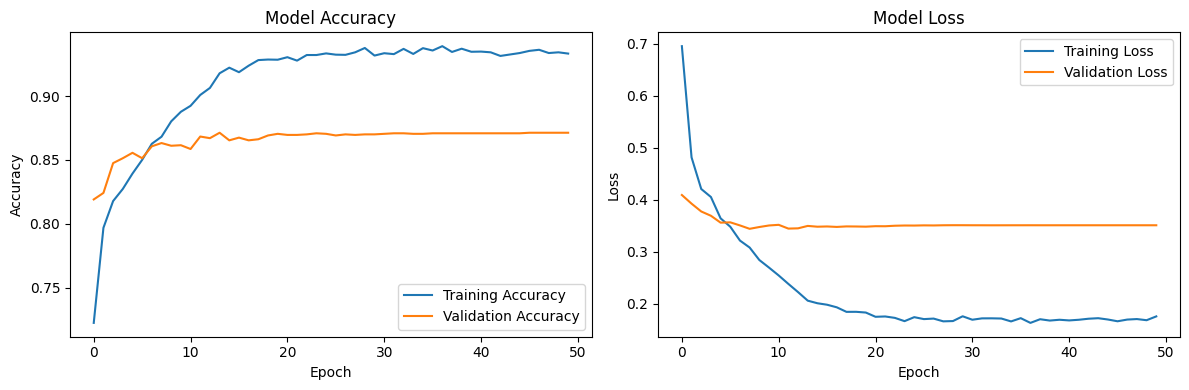

99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 231ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1864
           1       0.82      0.87      0.84      1276

    accuracy                           0.87      3140
   macro avg       0.86      0.87      0.86      3140
weighted avg       0.87      0.87      0.87      3140



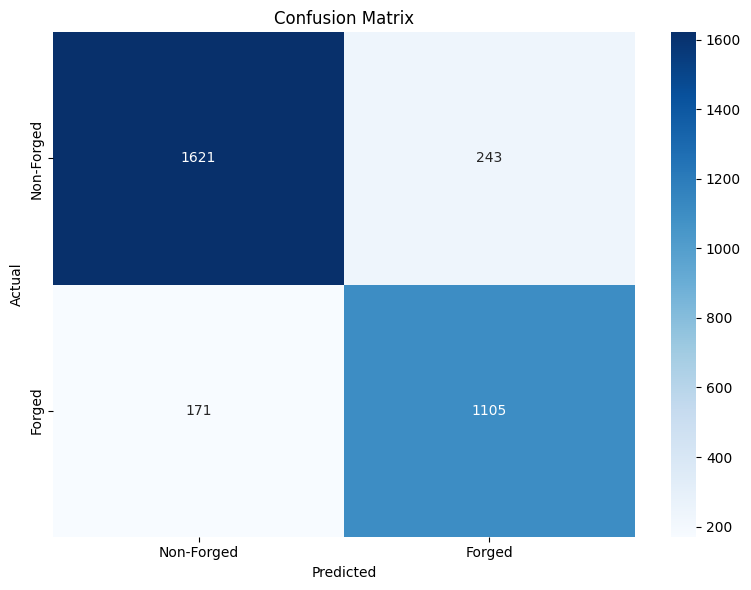


Model Performance Metrics:
Accuracy: 0.8682
Precision: 0.8197
Recall: 0.8660
F1_score: 0.8422


In [5]:
# Plot training curves
detector.plot_training_curves()

# Evaluate model
metrics = detector.evaluate_model(X_test, y_test)

# Print metrics
print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

# Save model
# detector.model.save('forgery_detection_model.h5')

In [6]:
detector.model.save('exported/forgery_detection_model_jan_2.h5')